In [1]:
! nvidia-smi

Thu Mar 28 09:51:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   3245MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [3]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy,imagenet_stats,load_learner
from fastai.vision import ShowGraph,partial
import torch

In [4]:
from pathlib import Path

## Prepare for loging

In [5]:
import json
import re
import ipykernel
import requests
from requests.compat import urljoin
from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path

from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [6]:
# vars for models logging
TRAIN_LOG_DIR = 'train_log'
NB_NAME = get_notebook_name()
MODEL_NAME = NB_NAME.split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0]) if len(x.split('.')[0]) >0 else 0
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/resnet18-fastai/036.28-03-2019-09-51'

In [7]:
NOTE = f"""
Note for version {version} model {MODEL_NAME}:
Train with bs=128 instead of 256
"""
print(NOTE)


Note for version 36 model resnet18-fastai:
Train with bs=128 instead of 256



### Init data loader

In [8]:
data_path = '/home/qnkhuat/data/emotion_compilation_split_no_affectnet'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=20,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=128)
       .normalize())
data

ImageDataBunch;

Train: LabelList (24336 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split_no_affectnet;

Valid: LabelList (6957 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split_no_affectnet;

Test: LabelList (3479 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: EmptyLabelList
,,,,
Path: /home/qnkhuat/data/emotion_compilation_split_no_affectnet

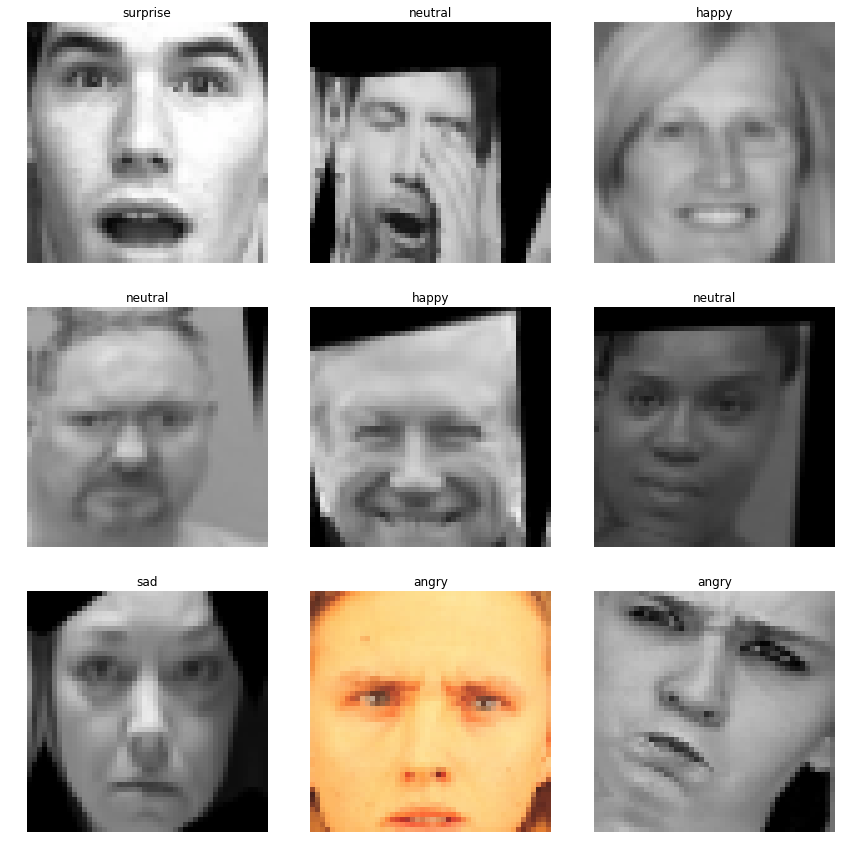

In [15]:
data.show_batch(rows=3)

## Init model

In [9]:
model = models.resnet18

In [10]:
learn = cnn_learner(data, model,callback_fns=[ShowGraph])
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.path = Path('.')
learn.model_dir = model_save_dir
learn.metrics = [accuracy]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


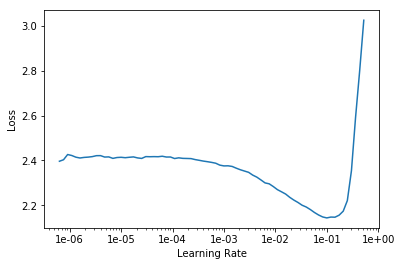

In [11]:
learn.lr_find()
learn.recorder.plot()

## Start training

In [12]:
lr=5e-2

In [13]:
learn.fit_one_cycle(12,max_lr = slice(1e-4,lr))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [21]:
learn.save('stage-1')

# Unfreeze

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


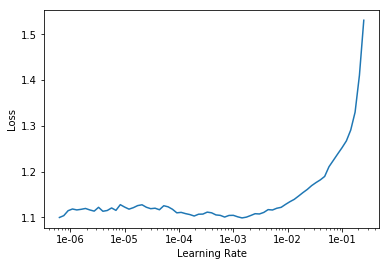

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.854837,0.756986,0.734512,00:39
1,0.768585,0.682096,0.749317,00:39
2,0.696487,0.646814,0.766135,00:39
3,0.646297,0.635712,0.763835,00:39


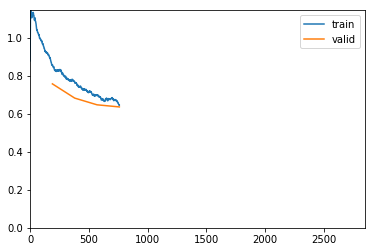

KeyboardInterrupt: 

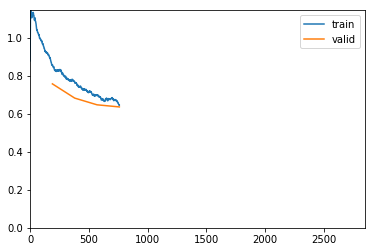

In [24]:
learn.fit(15)

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(15,slice(1e-5,lr/5))

In [35]:
learn.save('stage-3')

# Freeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


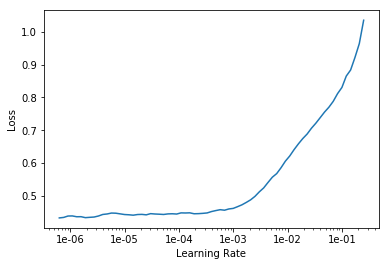

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.445814,0.633246,0.788271,00:18
1,0.459538,0.632213,0.788271,00:18
2,0.455076,0.634563,0.789708,00:18
3,0.453962,0.635828,0.787696,00:18
4,0.451050,0.638055,0.787552,00:18
5,0.445835,0.637852,0.787696,00:17
6,0.449663,0.636526,0.787265,00:19
7,0.443009,0.636698,0.787983,00:18
8,0.439712,0.636335,0.789133,00:17


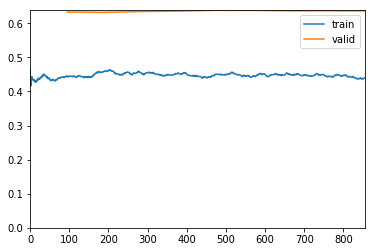

In [38]:
learn.fit_one_cycle(9,slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.366423,0.550227,0.814575,00:36
1,0.357310,0.550073,0.814000,00:40
2,0.365944,0.549160,0.813282,00:36
3,0.369601,0.548583,0.814144,00:39
4,0.363898,0.549705,0.813569,00:34
5,0.364938,0.551574,0.813713,00:39
6,0.362394,0.550372,0.815006,00:38
7,0.356316,0.547442,0.815725,00:39
8,0.357589,0.546669,0.813857,00:38
9,0.361949,0.547864,0.814719,00:36


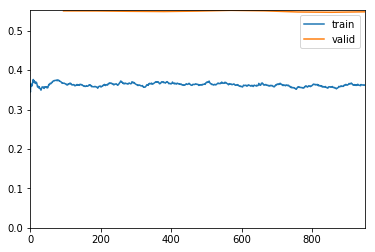

In [36]:
learn.fit(10,lr=1e-5)

In [37]:
learn.save('stage-4')

In [38]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

81.77375197410583


In [40]:
#learn.export()

# Train with bigger images

In [41]:
data_path = '/home/qnkhuat/data/emotion_compilation_split_no_affectnet'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=20,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=96,ds_tfms=tfms,bs=256)
       .normalize())


In [42]:
learn.data = data

In [43]:
# initial

In [44]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(12,lr)

# unfreeze

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
learn.fit(12,lr)

# Refreeze

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cyle(12,lr)

# Remember to save the checkpoint before run this

In [46]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:5]+'.html'
os.system(f"jupyter nbconvert {NB_NAME} --output {nb_name}")

content = f'{version} - {str(tta)[:4]}'
with open(f"{pjoin(TRAIN_LOG_DIR)}/{NB_NAME.split('.')[0]}.txt",'a') as f :
    f.write(content)
    f.writelines(NOTE)

This notebook has been saved


NameError: name 'tta' is not defined